In this series I want to accomplish a simple task: stitch two images together. This is a pretty standard task in computer vision and image processing, and it has a lot of elements with lots of small details - iterating through images, comparing pixel values, interpolation, matrix operations, and more.

When I first started this task I thought it would be a piece of cake, but I'd forgotten how many steps and details there are, so I'm going to split this task across two posts. To break it down, here are the steps required:

1. Extract feature points (_Part 1_)
2. Calculate descriptors (_Part 1_)
3. Match points (_Part 1_)
4. Calculate transformation (_Part 2_)
5. Stitch images (_Part 2_)

This notebook covers _Part 1_, everything from feature points to matching. In the next post I'll take a look at how to actually do the stitching.

# Setting up and loading images

There is a package made by the JuliaImages community called [ImageFeatures.jl](https://github.com/JuliaImages/ImageFeatures.jl) that implements lots of feature extraction methods. It isn't committed to the Julia METADATA.jl packages directory, but the awesome thing is that you can still clone the package locally by doing:

    Pkg.clone("https://github.com/JuliaImages/ImageFeatures.jl");

Or, when you have it installed and want to udpate: 

    Pkg.update("ImageFeatures");
    
Pretty cool that in Julia, packages can just be Github repositories!

In [1]:
summary(img1)

LoadError: UndefVarError: img1 not defined

In [2]:
summary(img1)

LoadError: UndefVarError: img1 not defined

In [3]:
using ImageFeatures, Images, FileIO;

INFO: Recompiling stale cache file /home/mprat/.julia/lib/v0.5/IntervalSets.ji for module IntervalSets.
INFO: Recompiling stale cache file /home/mprat/.julia/lib/v0.5/Images.ji for module Images.
INFO: Recompiling stale cache file /home/mprat/.julia/lib/v0.5/Distributions.ji for module Distributions.


As a set of sample images to use for the stitching exercise, I took two pictures of the [Stata Center](https://en.wikipedia.org/wiki/Ray_and_Maria_Stata_Center) at MIT. It is home to CSAIL (the Computer Science and Artificial Intelligence Laboratory), where I and many others spend much of our MIT careers in. I really like using it as a case study for image stitching because as you can see, the building is pretty weird, leaving many opportunities for feature detection to go wrong!

In [4]:
img1 = load("imgs/stata-1.png")
img2 = load("imgs/stata-2.png")
[img1 img2]

INFO: Recompiling stale cache file /home/mprat/.julia/lib/v0.5/ImageMagick.ji for module ImageMagick.


In [5]:
size(img1)

(500,375)

# Extracting Feature Points

The first step to stitching two images together is finding feature points, sometimes called _keypoints_. The main purpose of feature points are to identify points in an image that are "interesting", for some value of interesting. When we are doing image stitching, we generally think points are interesting if they correspond to "corners" in the image. Basically, points at which boundaries happen between objects. The idea is that if we can identify points at the corners of objects, they are unique enough to match nicely if they appear in another image. Of course, this does not happen in practice, but it works fairly well, as we shall see later on.

One method to finding image corners is the `Harris corner` method, which uses the Sobel kernel (which I implemented and talked about in [my last post](http://learningjulia.com/2017/03/09/imfilter-and-arrays.html)) to find areas in the image that have strong gradients.

Thankfully, the `Images.jl` package we are familiar with implements [`imcorner`](https://github.com/JuliaImages/Images.jl/blob/f2b1ad762a18289f5f76fa1070debb460ed6e082/src/corner.jl):

In [6]:
?imcorner

search: imcorner



```
corners = imcorner(img; [method])
corners = imcorner(img, threshold, percentile; [method])
```

Performs corner detection using one of the following methods -

```
1. harris
2. shi_tomasi
3. kitchen_rosenfeld
```

The parameters of the individual methods are described in their documentation. The maxima values of the resultant responses are taken as corners. If a threshold is specified, the values of the responses are thresholded to give the corner pixels. The threshold is assumed to be a percentile value unless `percentile` is set to false.


This is the first time I've come across the Julia `method` type, so I assumed that I could just pass the function itself (in this case, the `harris` function):

In [7]:
# construct keypoints
features_1 = imcorner(img1, harris);

LoadError: MethodError: no method matching imcorner(::Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}, ::Images.#harris)[0m
Closest candidates are:
  imcorner(::AbstractArray{T,N}, ::Any, [1m[31m::Any[0m; method, args...) at /home/mprat/.julia/v0.5/Images/src/corner.jl:27
  imcorner(::AbstractArray{T,N}; method, args...) at /home/mprat/.julia/v0.5/Images/src/corner.jl:19[0m

But as you can see, it throws an error. Just to confirm, `harris` is a real Julia function in the `Images` package:

In [8]:
?harris

search: harris shareproperties SharedMatrix



```
harris_response = harris(img; [k], [border], [weights])
```

Performs Harris corner detection. The covariances can be taken using either a mean weighted filter or a gamma kernel.


So what's the problem? The problem is that in the `imcorner` function, `method` is a keyword argument, not a positional argument. How do you know that? Well, the function signature says:

    function imcorner(img::AbstractArray; method::Function = harris, args...)

In case you missed it, there is a `;` in between the `img` argument and the `method` argument. This means that the `img` argument is a positional argument, and everything after the `;` (starting from `method`), is a keyword argument. The difference is that for a keyword argument, you always have to specify what variable the argument maps to in the function signature, like this:

In [9]:
features_1 = imcorner(img1, method=harris);

In this case, `method` is a keyword argument and we explicitly have to specify it when calling `imcorner`.

Now our function calls work just fine! In Julia, positional arguments come before keyword arguments, and keyword arguments cannot be positional arguments. So once you define an argument after a semicolon, it must always be called with a keyword. You can read more about the differences between positional and keyword arguments [in the Julia docs](http://docs.julialang.org/en/stable/manual/functions/).

# Visualize keypoints

Let's see what type gets returned by `imcorner` and see if we can visualize the features.

In [10]:
summary(features_1)

"500×375 BitArray{2}"

In [11]:
sizeof(features_1)

23440

You can see that `features_1` is a `BitArray` - this means it is the same as a binary mask the size of our image. A "True" value at a given index means that pixel is a feature, "False" means it is not a feature. The cool thing about `BitArrays` is that they only store a single bit of information per entry, rather than say an array of booleans, which uses more bits. You can see that this `BitArray` only takes up 23440 bytes. (_aside: there are 8 bits in a byte, so $23440$ bytes $= 23440 \cdot 8 = 1875520$ bits $= 500 \cdot 375$ bits, one bit per entry in the `BitArray`_)

What I want to do is visualize the feature points by drawing a circle around the feature point. I'll do this by iterating over the `BitArray` and constructing a new one that stores the points that we will turn yellow.

In [12]:
function draw_points(image::AbstractArray, mask::BitArray{2}; c::Colorant=colorant"yellow")
    new_image = copy(image);
    new_image[mask] = c;
    return new_image;
end

draw_points (generic function with 1 method)

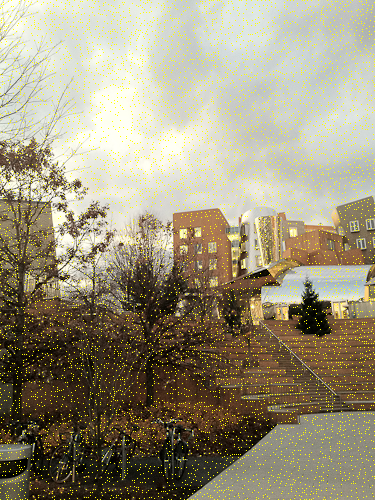

In [13]:
draw_points(img1, features_1)

This function works to draw our points, but it is not very generic. The `BitArray` size is encoded directly. We don't actually care of the `BitArray` has exactly 2 channels, all we want to know is that it is the same size as the image.

The way we do this is by defining `draw_points` parametrized by two values `T` and `N`. As far as I can tell by reading Julia package code, by convension `T` is used to represent "Type" and `N` is used to represent dimension. What this function header says is that for an image of type `T` with size `N`, make sure the `BitArray` mask has the same size. We do this to make sure the calling of the image on the mask doesn't yield an out of bound error.

You'll notice that I also include a color argument as a `colorant` from the [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) package. Because I specify a default value for this argument, I don't have to call `draw_points` by passing a color every time. If I don't, it will just use yellow.

In [14]:
function draw_points{T,N}(image::AbstractArray{T,N}, mask::BitArray{N}, c::Colorant=colorant"yellow")
    new_image = copy(image);
    new_image[mask] = c;
    return new_image;
end

draw_points (generic function with 3 methods)

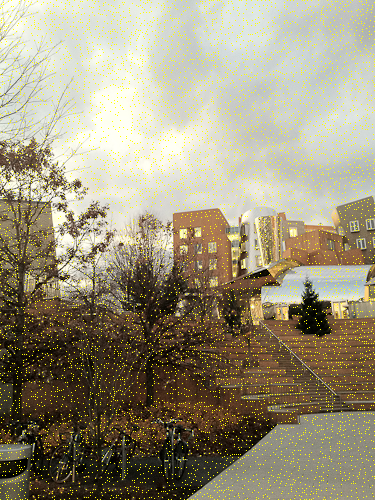

In [15]:
draw_points(img1, features_1)

Now let's see if we can use `Interact.jl` again to visualize the 3 different kinds of corner detectors implemented in `ImageFeatures`.

In [16]:
using Interact;

INFO: Recompiling stale cache file /home/mprat/.julia/lib/v0.5/Reactive.ji for module Reactive.


Interact.Options{:ToggleButtons,Function}(Signal{Function}(Images.harris, nactions=1),"m",Images.harris,"Images.harris",Interact.OptionDict(DataStructures.OrderedDict{String,Function}("Images.harris"=>Images.harris,"Images.shi_tomasi"=>Images.shi_tomasi,"Images.kitchen_rosenfeld"=>Images.kitchen_rosenfeld),Dict{Function,String}(Pair{Function,String}(Images.harris,"Images.harris"),Pair{Function,String}(Images.kitchen_rosenfeld,"Images.kitchen_rosenfeld"),Pair{Function,String}(Images.shi_tomasi,"Images.shi_tomasi"))),Any[],Any[],true,"horizontal")

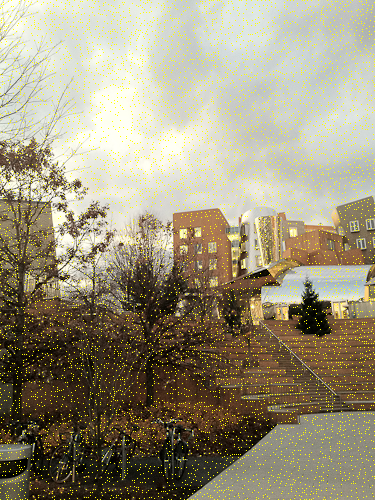

In [17]:
@manipulate for m=[harris, shi_tomasi, kitchen_rosenfeld]
    draw_points(img1, imcorner(img1, method=m))
end

As we can see, the differences are pretty minimal, so let's pick Harris corners to use as our keypoint locator and keep exploring parameters. We can see from `ImageFeatures` that the other way to call `imcorner` is to specify a percentile and a threshold.

If you specify `imcorner` WITHOUT these parameters, the function will compute a "local maximum response" of all neighbors, and only return points that have the maximum value of all of its neighbors. If you call `imcorner` with a percentile, the function does not do mean response and instead returns all the points above the percentile you specified. (Yet another way is to pass a threshold and "false", which just does thresholding without taking percentiles into account, but this is hard to calibrate across methods).

Choosing the local maximum response or the percentile method is one of choice. Usually, local maximum response means you don't have too many feature points that are very close together. This is great for downstream parts of your pipeline, since there are likely to be fewer feature points that look very much alike.

In [18]:
features_1 = imcorner(img1, 0.90, true, method=harris);

In [19]:
summary(features_1)

"500×375 Array{Bool,2}"

In [20]:
sizeof(features_1)

187500

One weird quirk of this method is that if you use `imcorner` and pass arguments, you don't get back a `BitArray`, but instead an `Array` of `Bool` values. Compared to the $23440$ bytes from the `BitArray` above, this takes $187500 = 500 \cdot 375$ bytes, which is $187500 * 8 = 1500000$ bits, or 8 times more bits.

However, this also means that our implementation for `draw_points` won't work. We specifically specified that the `mask` argument had to be a `BitArray`.

In [21]:
draw_points(img1, imcorner(img1, 0.90, true, method=harris))

LoadError: MethodError: no method matching draw_points(::Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2}, ::Array{Bool,2})[0m
Closest candidates are:
  draw_points(::AbstractArray{T,N}, [1m[31m::BitArray{2}[0m; c) at In[12]:2
  draw_points{T,N}(::AbstractArray{T,N}, [1m[31m::BitArray{N}[0m) at In[14]:2
  draw_points{T,N}(::AbstractArray{T,N}, [1m[31m::BitArray{N}[0m, [1m[31m::ColorTypes.Colorant{T,N}[0m) at In[14]:2[0m

What we can do is generalize our function a little bit more. Rather than forcing `mask` to be a `BitArray`, we can say that it has to be a type of `AbstractArray{Bool, N}`, the parent type of both `BitArray` and `Array{Bool}`. (Thanks [StackOverflow post](http://stackoverflow.com/questions/29623059/whats-the-difference-between-arraybool-and-bitarray-in-julia-and-how-are-they)).

In [22]:
BitArray <: AbstractArray{Bool}

true

In [23]:
Array{Bool} <: AbstractArray{Bool}

true

In [24]:
function draw_points{T,N}(image::AbstractArray{T,N}, mask::AbstractArray{Bool, N}, c::Colorant=colorant"yellow")
    new_image = copy(image);
    new_image[mask] = c;
    return new_image;
end

draw_points (generic function with 5 methods)

And now we can draw again!

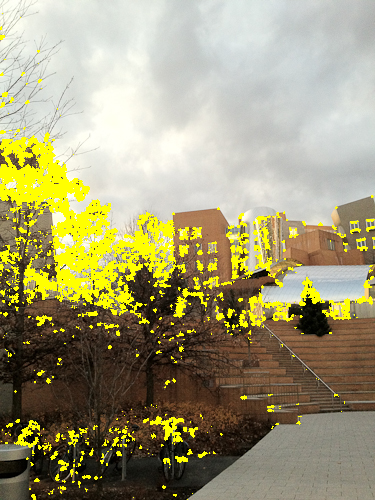

In [25]:
draw_points(img1, imcorner(img1, 0.90, true, method=harris))

Let's see how the percentile affects the Harris corners (I really love Interact!!)

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.7448979591836735, nactions=1),"percentile",0.7448979591836735,"0.7448979591836735",Interact.OptionDict(DataStructures.OrderedDict("0.5"=>0.5,"0.5102040816326531"=>0.510204,"0.5204081632653061"=>0.520408,"0.5306122448979592"=>0.530612,"0.5408163265306123"=>0.540816,"0.5510204081632653"=>0.55102,"0.5612244897959183"=>0.561224,"0.5714285714285714"=>0.571429,"0.5816326530612245"=>0.581633,"0.5918367346938775"=>0.591837…),Dict(0.622449=>"0.6224489795918368",0.663265=>"0.6632653061224489",0.602041=>"0.6020408163265306",0.795918=>"0.7959183673469388",0.908163=>"0.9081632653061225",0.846939=>"0.8469387755102041",0.591837=>"0.5918367346938775",0.693878=>"0.6938775510204082",0.959184=>"0.9591836734693877",0.55102=>"0.5510204081632653"…)),Any[],Any[],true,"horizontal")

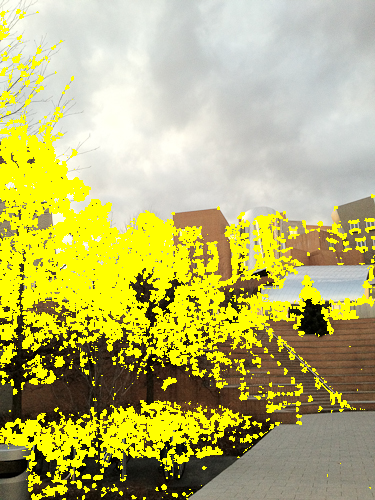

In [26]:
@manipulate for percentile=linspace(0.5, 1.0, 50)
    draw_points(img1, imcorner(img1, percentile, true, method=harris))
end

From the outputs, I think we can safely say that the local-max response is the best option for finding feature points of those built into `Images.jl` - the points are not densely clustered, and we can match them more easily.

Of course, we can combine the two methods, just for kicks:

In [27]:
function corners_percentile_and_local_maximum(img::AbstractArray, percentile)
    percentile_corners = imcorner(img, percentile, true, method=harris)
    corners = falses(size(percentile_corners))
    maxima = map(CartesianIndex{2}, findlocalmaxima(percentile_corners))
    corners[maxima] = true
    return corners
end

corners_percentile_and_local_maximum (generic function with 1 method)

Interact.Options{:SelectionSlider,Float64}(Signal{Float64}(0.49489795918367346, nactions=1),"percentile",0.49489795918367346,"0.49489795918367346",Interact.OptionDict(DataStructures.OrderedDict("0.01"=>0.01,"0.030204081632653063"=>0.0302041,"0.05040816326530612"=>0.0504082,"0.07061224489795918"=>0.0706122,"0.09081632653061225"=>0.0908163,"0.1110204081632653"=>0.11102,"0.13122448979591836"=>0.131224,"0.15142857142857144"=>0.151429,"0.1716326530612245"=>0.171633,"0.19183673469387755"=>0.191837…),Dict(0.313061=>"0.3130612244897959",0.616122=>"0.6161224489795918",0.434286=>"0.4342857142857143",0.515102=>"0.5151020408163265",0.575714=>"0.5757142857142857",0.131224=>"0.13122448979591836",0.656531=>"0.656530612244898",0.272653=>"0.2726530612244898",0.0706122=>"0.07061224489795918",0.252449=>"0.2524489795918367"…)),Any[],Any[],true,"horizontal")

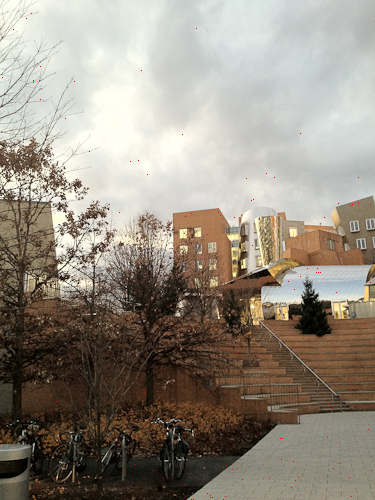

In [28]:
@manipulate for percentile=linspace(0.01, 1.0, 50)
    draw_points(img1, corners_percentile_and_local_maximum(img1, percentile), c=colorant"red")
end

As you can see, the resulting corners are very sparse (perhaps too sparse for our needs), so we're just going to stick to the plain old Harris corner detector without playing with percentiles.

# Calculate descriptors

Now that we have points on the image that we think are interesting, we want to compute a description of each point that will hopefully help us when trying to find similar points in another image. The purpose of a feature descriptor is to store information about the "orientations" of edges and their magnitudes. The idea is that edges have directionality - a horizontal edge that is darker on the top half is different than a horizontal edge that is darker on the bottom half. So if you are eventually looking to match edges (or corners) from two images together, you need to somehow encode the directionality of these edges in what we call feature descriptors.

There are many options for feature descriptors. You might have heard of SIFT feature points - those work well, except for two problems: (1) the SIFT algorithm is patented, so you can't use it without paying license fees, and (2) SIFT generates a 128-dimensional vector for all the feature points. The good news is that feature descriptors like BRISK, BRIEF, and ORB were created that have similar properties to SIFT while being free and open, and they use fewer bits of information!

The `ImageFeatures` package provides convenient wrappers around keypoints and features, since this is a pretty common operation in image processing. Of course, this means I'll have to make a new `draw_points()` method to see my keypoints. But no biggie, it's the same code. `Keypoints` can be constructed from a `BitArray` or an `Array{Bool}`, so we are in the clear.

In [29]:
function draw_points(image::AbstractArray, mask::Keypoints; c::Colorant=colorant"yellow")
    new_image = copy(image);
    new_image[mask] = c;
    return new_image;
end

draw_points (generic function with 6 methods)

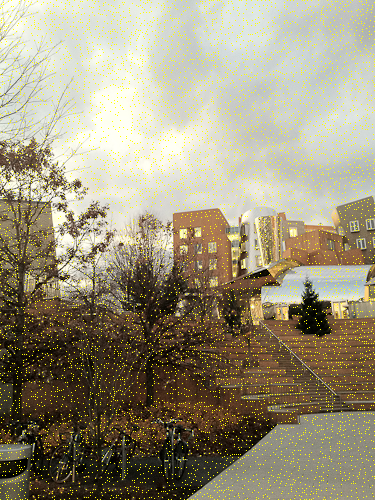

In [30]:
draw_points(img1, Keypoints(imcorner(img1, method=harris)))

The thing to note is that usually the feature descriptors are calculated a the grayscale version of an image. As it turns out, the information stored in Red, Green, and Blue channels are redundant (_self-aside: maybe I'll do an exploratory post on that at some future date_), so you really only need to use a single channel that describes all of them to calculate descriptors. Let's say we want to calculate BRISK features on our image. It computes a vector of binary features (i.e. 0s and 1s) that determine whether a particular orientation is present for that keypoint. There's a pretty good graphic on the `ImageFeatures.jl` docs page about how to visualize the regions used by BRISK features - you can [find it here](http://juliaimages.github.io/ImageFeatures.jl/latest/tutorials/brisk/).

`ImageFeatures` provides an interface for creating a descriptor, but first we need to convert our keypoints to the `Feature` type so we can store the orientations for each feature point.

In [31]:
?Features

search: Features ImageFeatures feature_transform Feature



```
features = Features(boolean_img)
features = Features(keypoints)
```

Returns a `Vector{Feature}` of features generated from the `true` values in a boolean image or from a  list of keypoints.


In [38]:
brisk_params = BRISK();
features_1 = Features(Keypoints(imcorner(img1, method=harris)));
desc_1, ret_features_1 = create_descriptor(Gray.(img1), features_1, brisk_params);

If we calculate the descriptors for both images, we can use the `match_keypoints` function to match both images. What it does (as implemented in `ImageFeatures`), is match feature points computed on two images using a Hamming Distance function, since BRISK features output a set of binary vectors for each keypoint. The `Hamming Distance` is basically "how many bits different" are two vectors. So the vectors `[1, 1, 1]` and `[0, 0, 0]` have a Hamming Distance of 3, while the vectors `[1, 1, 1]` and `[1, 1, 0]` have a Hamming Distance of 1.

I'm going to make a wrapper `get_descriptors` function so I don't need to remember all the arguments to pass.

In [33]:
function get_descriptors(img::AbstractArray)
    brisk_params = BRISK();
    features = Features(Keypoints(imcorner(img, method=harris)));
    desc, ret_features = create_descriptor(Gray.(img), features, brisk_params);
end

function match_points(img1::AbstractArray, img2::AbstractArray, threshold::Float64=0.1)
    desc_1, ret_features_1 = get_descriptors(img1);
    desc_2, ret_features_2 = get_descriptors(img2);
    matches = match_keypoints(Keypoints(ret_features_1), Keypoints(ret_features_2), desc_1, desc_2, threshold);
    return matches;
end

match_points (generic function with 2 methods)

We can then use these matches to draw a line between the matched points from the two images. I'll need to install [ImageDraw](https://github.com/JuliaImages/ImageDraw.jl) to make that work, because it implements a [`line`](https://github.com/JuliaImages/ImageDraw.jl/blob/master/src/line2d.jl#L3) function to draw a line between two points on an image. It is not an official package yet, so we just clone it from Github the same way we did with `ImageFeatures`.

In [34]:
# Pkg.clone("https://github.com/JuliaImages/ImageDraw.jl");
using ImageDraw;

In [35]:
matches = match_points(img1, img2, 0.1);

In [36]:
function draw_matches(img1, img2, matches)
    grid = [img1 img2];
    offset = CartesianIndex(0, size(img1, 2));
    for m in matches
        line!(grid, m[1], m[2] + offset)
    end
    grid
end

draw_matches (generic function with 1 method)

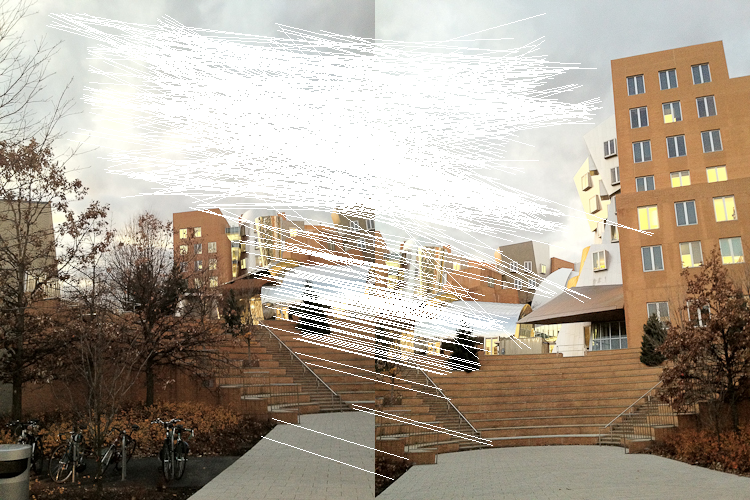

In [37]:
draw_matches(img1, img2, matches)

You can see that we get some pretty decent results! The sky is problematic, but skies are always going to be problematic, so I'm not too worried. We can probably get rid of that at the filtering and stitching stage in the next post.

However, to do the actual stitching we'll have to use the matched points to compute a transformation from one image to another (known as a homography), while rejecting the bad matches. Then we'll have to actually do the image stitching portions and correct any errors there.

Join me next time when I explore homographies, image transformations, and stitching. I found [this package](https://github.com/peterkovesi/ImageProjectiveGeometry.jl) about projective geometry, so maybe I'll take a look at that one!